In [84]:
import numpy as np
from UAV import *
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt           # for plotting

### Definition of the Distance Matrix

In [85]:
n_robots = 3#int(input("number of robots: "))
platoon = []

c_set = ['black'] + ['green' for i in range(1,n_robots)]

# initialization of n robots
for i in range(n_robots):
    i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

S = coordinates[0:2,:]

DM  = d_matrix(platoon)
DM2 = d_matrix2(platoon)
print(DM)
print(DM2)

[[0.         6.10398211 5.70732372]
 [6.10398211 0.         8.37068749]
 [5.70732372 8.37068749 0.        ]]
[[ 0.         37.25859758 32.57354408]
 [37.25859758  0.         70.06840913]
 [32.57354408 70.06840913  0.        ]]


### Identity matrix

In [86]:
I   = np.eye(n_robots)
print(I)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Definition of the e vector and the H matrix

In [87]:
e   = np.array([[1] for i in range(n_robots)])

H = I - (e*e.T)/n_robots
print(H)

[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


### Eigendecomposition of the matrix -1/2HDH

In [88]:
print(-1/2*H*DM*H,'\n')

#Eigenvalues ev, eigenvectors EV
ev,EV = np.linalg.eig(-1/2*H*DM*H)

#Lambda is the diagonal matrix whose elements are the eigenvalues
LAMBDA = np.eye(n_robots)*ev

#U is the matrix whose columns are the eigenvectors
U      = np.transpose(EV)
print(LAMBDA,'\n\n',U)

#Sstar  = np.sqrt(LAMBDA).transpose(U)
#print(Sstar)

[[-0.         -0.33911012 -0.31707354]
 [-0.33911012 -0.         -0.46503819]
 [-0.31707354 -0.46503819 -0.        ]] 

[[-0.75156708  0.          0.        ]
 [-0.          0.28549504  0.        ]
 [-0.          0.          0.46607205]] 

 [[-0.52540884 -0.60638133 -0.59686451]
 [-0.84827326  0.31876116  0.42287562]
 [ 0.06616666 -0.72848679  0.681857  ]]


### Scikit learn MDS approach

In [89]:
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,
                n_init = 50,
                max_iter = 10000,
                eps=1e-5,
                dissimilarity='precomputed') # instantiate and set the hyperparameter
                
Sstar = embedding.fit_transform(DM).T

print(Sstar)
print(S)

[[ 2.37364771 -3.59660576  1.22295804]
 [-1.44271923 -2.70252316  4.14524238]]
[[9.05748067 6.68541453 3.80628954]
 [3.49397111 9.11819549 1.25823058]]


#### Plot

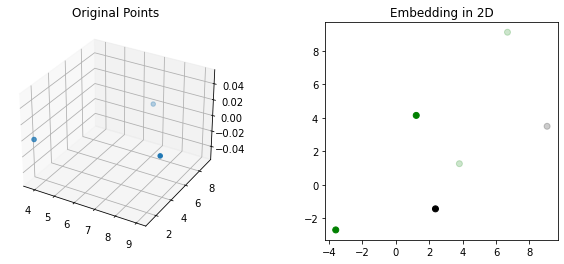

In [90]:
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(coordinates[0,:], coordinates[1,:], coordinates[2,:])
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

### Introduction of the controlled displacement

In [91]:
deltaX = deltaY = 0.1

deltaSprime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
deltaSprime[:,0] = [deltaX,deltaY]
print(deltaSprime)

[[0.1 0.  0. ]
 [0.1 0.  0. ]]


In [92]:
Sprime = S + deltaSprime
print(Sprime)

[[9.15748067 6.68541453 3.80628954]
 [3.59397111 9.11819549 1.25823058]]


### Phi prime definition

In [93]:
Phiprime = np.array([np.diag(Sprime.T@Sprime)]).T
print(Phiprime)

DMprime = Phiprime@e.T - 2*Sprime.T@Sprime + e@Phiprime.T

[[ 96.77608059]
 [127.83625637]
 [ 16.07098421]]


Let's have a look at the distance matrices. They are pretty similar, since the displacement is very small. GOOD

In [94]:
print(DMprime)
print(DM2)

[[ 0.         36.62816594 34.09093041]
 [36.62816594  0.         70.06840913]
 [34.09093041 70.06840913  0.        ]]
[[ 0.         37.25859758 32.57354408]
 [37.25859758  0.         70.06840913]
 [32.57354408 70.06840913  0.        ]]


DMprime breakdown analysis (as on the paper)

In [95]:
piece1 = DM2 - DMprime
print(piece1)

[[ 0.          0.63043165 -1.51738633]
 [ 0.63043165  0.          0.        ]
 [-1.51738633  0.          0.        ]]


In [96]:
piece2 = np.zeros((n_robots,n_robots))
piece2[1:,0] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
piece2[0,1:] = (deltaX**2 + deltaY**2)*np.ones(n_robots-1)
print(piece2)

[[0.   0.02 0.02]
 [0.02 0.   0.  ]
 [0.02 0.   0.  ]]


In [97]:
piece3 = -2*((S.T@deltaSprime).T + S.T@deltaSprime)
print(piece3)

[[-5.02058071 -3.160722   -1.01290402]
 [-3.160722   -0.         -0.        ]
 [-1.01290402 -0.         -0.        ]]


In [98]:
#FINAL RESULT [SHOULD BE VERY CLOSED TO ZERO --> GOOD]
print(piece1+piece2+piece3)

[[-5.02058071 -2.51029036 -2.51029036]
 [-2.51029036  0.          0.        ]
 [-2.51029036  0.          0.        ]]


In [99]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)    

sinTheta = (a3*b2-a2*b3)/(b3*c2-b2*c3)
cosTheta = (a2*c3-a3*c2)/(b3*c2-b2*c3)
print(sinTheta,cosTheta)
theta = np.arctan2(sinTheta,cosTheta)
print('Theta: %f' % (theta))

mod = np.sqrt(sinTheta**2+cosTheta**2)
sinTheta /= mod
cosTheta /= mod

theta = np.arctan2(sinTheta,cosTheta)

print('Theta: %f' % (theta))
print(sinTheta**2+cosTheta**2)


-1.2798862992881084 -0.6979508380006503
Theta: -2.070041
Theta: -2.070041
0.9999999999999998


In [100]:
#rotMatrix = np.array([[cosTheta,sinTheta],[-sinTheta,cosTheta]])
print(rotateMatrix(theta))

[[-0.4787628  -0.87794429]
 [ 0.87794429 -0.4787628 ]]


In [101]:
#Flip matrix
F = np.array([[-1,0],[0,1]])
print(F)

[[-1  0]
 [ 0  1]]


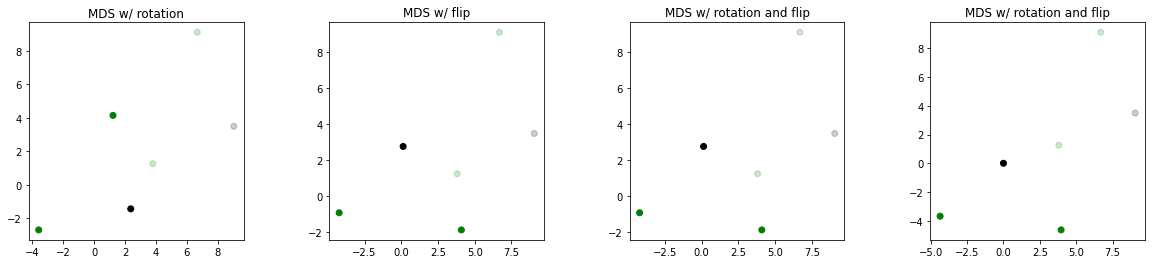

[[ 0.13021287  4.09458583 -4.2247987 ]
 [ 2.77465076 -1.86375193 -0.91089883]]
[[9.05748067 6.68541453 3.80628954]
 [3.49397111 9.11819549 1.25823058]]


In [102]:
S2 = rotateMatrix(theta)@Sstar
S3 = rotateMatrix(np.pi)@rotateMatrix(theta+np.pi)@Sstar

fig = plt.figure(3, (20,4))
ax = fig.add_subplot(141)
plt.scatter(Sstar[0,:], Sstar[1,:], color=c_set, alpha=1.0)
plt.scatter(S    [0,:], S    [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(142)
plt.scatter(S2[0,:], S2[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(143)
plt.scatter(S3[0,:], S3[1,:], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)

ax = fig.add_subplot(144)
plt.scatter(S3[0,:]-[S3[0,0] for _ in range(n_robots)], S3[1,:]-[S3[1,0] for _ in range(n_robots)], color=c_set, alpha=1.0)
plt.scatter(S [0,:], S [1,:], color=c_set, alpha=0.2)
plt.title('MDS w/ rotation and flip')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()

print(S2)
print(S)

### Flip and Rotation: Simultaneously

In [103]:
a2 = DM2[0,1] - DMprime[0,1] + deltaX**2 + deltaY**2
b2 = -2*(Sstar[0,1]*deltaX + Sstar[1,1]*deltaY)    
c2 =  2*(Sstar[0,1]*deltaY - Sstar[1,1]*deltaX)    

a3 = DM2[0,2] - DMprime[0,2] + deltaX**2 + deltaY**2
b3 = -2*(Sstar[0,2]*deltaX + Sstar[1,2]*deltaY)     
c3 =  2*(Sstar[0,2]*deltaY - Sstar[1,2]*deltaX)  

Coincise form, as seen on eqs (27) and (28) in the paper

In [105]:
theta11 = theta_i1(Sstar,S,1)
THETA1  = THETA_i (S,[deltaX,deltaY],1)
theta12 = theta_i2(theta11,THETA1)

theta21 = theta_i1(Sstar,S,2)
THETA2  = THETA_i (S,[deltaX,deltaY],2)
theta22 = theta_i2(theta11,THETA2)

If theta11 != theta21, there exists flip

In [ ]:
print(theta11,theta21)
print(theta12,theta22)


2.7717025253477257 0.4382528965196504
-2.054145831089979 1.2520304240402627
